In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU
from keras import optimizers 
from sklearn.preprocessing import MinMaxScaler

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

Using TensorFlow backend.


# Import Data

In [2]:
dataraw = pd.read_csv('BTC-USD.csv',index_col='Date', parse_dates=['Date'])
dataraw

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2020-07-05,9126.090820,9162.183594,8977.015625,9073.942383,9073.942383,12903406143
2020-07-06,9072.849609,9375.474609,9058.664063,9375.474609,9375.474609,17889263252
2020-07-07,9349.161133,9360.617188,9201.815430,9252.277344,9252.277344,13839652595


# Feature Selection

In [3]:
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(dataraw['Close'])
print(dataset.describe())
print(' Count row of data: ',len(dataset))

              Close
count   2123.000000
mean    4190.018268
std     4030.549406
min      178.102997
25%      424.749496
50%     3378.939941
75%     7531.821777
max    19497.400390
 Count row of data:  2123


# Preprocessing Data

### Normalization Min-Max

In [4]:
#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2014-09-17,0.014453
2014-09-18,0.012751
2014-09-19,0.011216
2014-09-20,0.011947
2014-09-21,0.011425
...,...
2020-07-05,0.460464
2020-07-06,0.476072
2020-07-07,0.469695


### Graph Data Normalized

D:\application\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


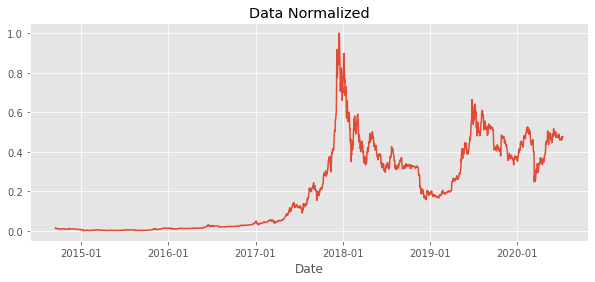

In [5]:
fig = plt.figure(figsize=(10, 4))
plt.plot(dataset_norm)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

# Data Partition

In [6]:
# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

# Graph Training Data

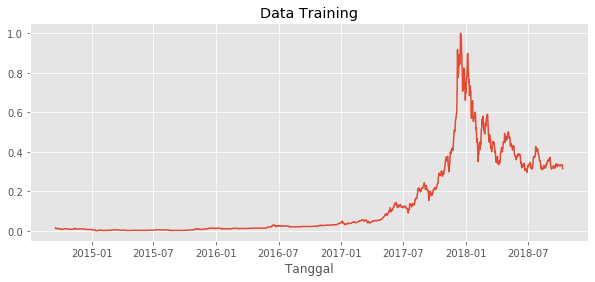

In [7]:
# graph data training
fig = plt.figure(figsize=(10, 4))
plt.plot(training_set)
plt.xlabel('Tanggal')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Training')
plt.show()

# Grafik Data Validation

Text(0.5, 1.0, 'Data Validation')

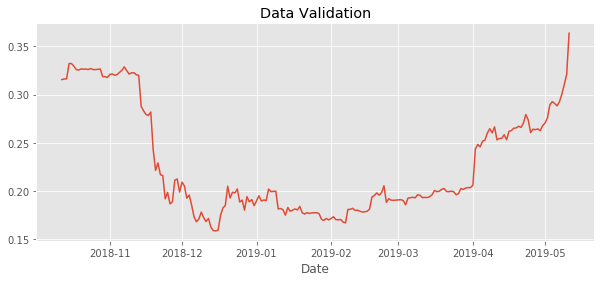

In [8]:
# graph data validation
fig = plt.figure(figsize=(10, 4))
plt.plot(val_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Validation')

# Grafik Data Test

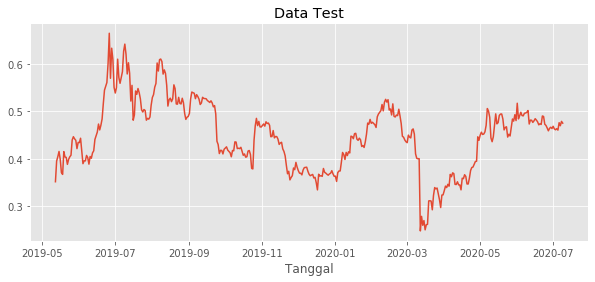

In [9]:
# graph data test
fig = plt.figure(figsize=(10, 4))
plt.plot(test_set)
plt.xlabel('Tanggal')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Test')
plt.show()

# Sliding Windows

In [10]:
# Initiaton value of lag
lag = 2
# Fungsi sliding windows
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Model GRU

In [11]:
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size=256
epoch = 100

# Architecture Gated Recurrent Unit
regressorGRU = Sequential()

# First GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))

# Output layer
regressorGRU.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
regressorGRU.compile(optimizer=optimizers.adam(lr=learning_rate),loss='mean_squared_error')

# Fitting ke data training dan data validation
pred = regressorGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

Train on 1484 samples, validate on 210 samples
Epoch 1/100
1484/1484 [==============================] - 7s 5ms/step - loss: 0.0553 - val_loss: 0.0489
Epoch 2/100
1484/1484 [==============================] - 0s 219us/step - loss: 0.0515 - val_loss: 0.0440
Epoch 3/100
1484/1484 [==============================] - 0s 189us/step - loss: 0.0476 - val_loss: 0.0393
Epoch 4/100
1484/1484 [==============================] - 0s 174us/step - loss: 0.0443 - val_loss: 0.0347
Epoch 5/100
1484/1484 [==============================] - 0s 180us/step - loss: 0.0413 - val_loss: 0.0304
Epoch 6/100
1484/1484 [==============================] - 0s 201us/step - loss: 0.0379 - val_loss: 0.0263
Epoch 7/100
1484/1484 [==============================] - 0s 176us/step - loss: 0.0351 - val_loss: 0.0224
Epoch 8/100
1484/1484 [==============================] - 0s 167us/step - loss: 0.0324 - val_loss: 0.0187
Epoch 9/100
1484/1484 [==============================] - 0s 181us/step - loss: 0.0296 - val_loss: 0.0154
Epoch 10/1

1484/1484 [==============================] - 0s 186us/step - loss: 9.8535e-04 - val_loss: 1.4265e-04
Epoch 76/100
1484/1484 [==============================] - 0s 171us/step - loss: 9.5617e-04 - val_loss: 1.4891e-04
Epoch 77/100
1484/1484 [==============================] - 0s 178us/step - loss: 0.0011 - val_loss: 1.4473e-04
Epoch 78/100
1484/1484 [==============================] - 0s 160us/step - loss: 0.0011 - val_loss: 1.4160e-04
Epoch 79/100
1484/1484 [==============================] - 0s 177us/step - loss: 0.0011 - val_loss: 1.2091e-04
Epoch 80/100
1484/1484 [==============================] - 0s 167us/step - loss: 0.0011 - val_loss: 1.2446e-04
Epoch 81/100
1484/1484 [==============================] - 0s 170us/step - loss: 0.0012 - val_loss: 1.4493e-04
Epoch 82/100
1484/1484 [==============================] - 0s 175us/step - loss: 0.0011 - val_loss: 1.6069e-04
Epoch 83/100
1484/1484 [==============================] - 0s 182us/step - loss: 8.6430e-04 - val_loss: 1.4263e-04
Epoch 84/10

## Graph training loss & validation loss

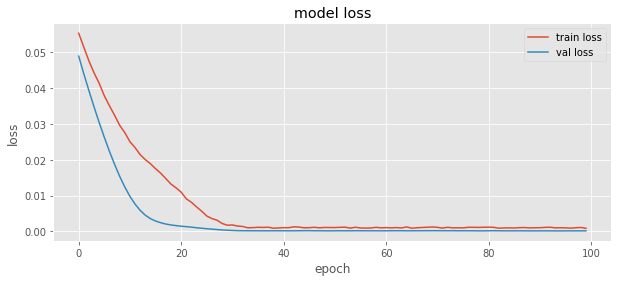

In [12]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# Tabel Training Loss & Validation Loss

In [13]:
# Tabel value of training loss & validation loss
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.000827,0.000129


# Implementation model into data test

In [14]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)


# Comparasion data test with prediction results

In [15]:
# Comparasion data test with data prediction
databanding = pd.DataFrame()
datatest=np.array(dataset['Close'][totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

databanding['Data Test'] = datatest
databanding['Prediction Results'] = datapred
databanding

,Data Test,Prediction Results
0,7994.416016,7101.014648
1,8205.167969,7735.211426
2,7884.909180,7925.000000
3,7343.895508,7968.787598
4,7271.208008,7578.352051
...,...,...
418,9073.942383,8971.625977
419,9375.474609,8984.236328
420,9252.277344,9039.590820
421,9428.333008,9208.821289


## Evaluasi Hasil Prediksi

In [16]:
# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Hasil Root Mean Square Error model prediksi :',rmse(datatest, datapred))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Hasil Mean Absolute Percentage Error : ', mape(datatest, datapred), '%')

Hasil Root Mean Square Error model prediksi : 1994.6846
Hasil Mean Absolute Percentage Error :  18.5991 %


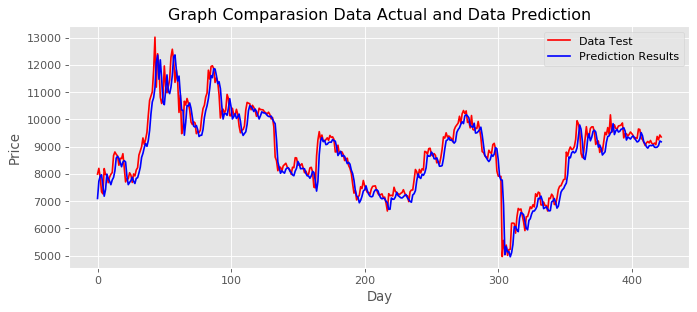

In [17]:
# Create graph data test and prediction result
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparasion Data Actual and Data Prediction')
plt.plot(databanding['Data Test'], color='red',label='Data Test')
plt.plot(databanding['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()
